In [ ]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
import seaborn as sb
import deepdish as dd
import seaborn as sns
from utils_openmax import *

seed = 42
np.random.seed(seed=seed)


data_setting = 'rawflt'
nb_classes = 2
splitting = 'custom'
if data_setting.startswith('raw'):
    model_setting = 'dl4tsc_inc'#'dl4tsc_inc'#'conv1d'
else:
    model_setting = 'DenseNet121'

### data collecting

In [15]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    13636
0     4172
dtype: int64

val: 
1    4542
0    1394
dtype: int64

test: 
1    12337
0     1950
dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
X_test, X_calibopenmax, y_test, y_calibopenmax = train_test_split(X_test, y_test, test_size=0.15, shuffle=True, random_state=42)

In [7]:
lg = DatasetConfiguration(names=['LG'])
lg.select(name='LG', species=['LG_zapr_26_09'])
lg.read()

y_zap = lg.labels.apply(lambda x: 2).values
X_zap = lg.fnames.tolist()

# print(len(X_test), len(y_test))
# X_test.extend(X_zap)
# y_test.extend(y_zap)
# print(len(X_test), len(y_test))

Dataset - LG - exists: True


## Loading model

In [17]:
splitting = 'custom'
modelname = f'{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5'

traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting, model_name=modelname)
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes).config
print(f"Model name: {modelname}")
model.load_weights(modelname)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model name: /home/kalfasyan/projects/wingbeat_frequencies/temp_data//Flies_rawflt_dl4tsc_inc_custom.h5


In [18]:
base_output = model.layers[-2].output
# new_output = Dense(nb_classes, activation="softmax")(base_output)
newmodel = Model(inputs=model.inputs, outputs=base_output)
newmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
if False:
    pred = newmodel.predict(valid_generator(X_train, y_train,
                                         batch_size=traincf.batch_size,
                                         target_names=np.unique(y_test).tolist(),
                                         setting=traincf.setting,
                                         preprocessing_train_stats=''),
                         steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))
    from utils_openmax import *
    mavs, scores = compute_mavs_and_scores(pred, y_train, nb_classes=2)
    dists = calc_dists(mavs,scores)
    joblib.dump(scores, os.path.join(TEMP_DATADIR, "train_scores.joblib"))
    joblib.dump(mavs, os.path.join(TEMP_DATADIR, "mavs.joblib"))
    joblib.dump(dists, os.path.join(TEMP_DATADIR, "dists.joblib"))
else:
    import joblib
    scores = joblib.load( os.path.join(TEMP_DATADIR, "train_scores.joblib"))
    mavs = joblib.load( os.path.join(TEMP_DATADIR, "mavs.joblib"))
    dists = joblib.load( os.path.join(TEMP_DATADIR, "dists.joblib"))

In [21]:
predval = newmodel.predict(valid_generator(X_calibopenmax, y_calibopenmax,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_val).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_calibopenmax))/float(traincf.batch_size))))
scoresval = compute_test_or_val_scores(predval, y_calibopenmax, nb_classes=2)
validate_openmax(mavs,dists,scoresval,np.array(y_calibopenmax),distance_type='eucos')


Testing tailsize: 4,alpha: 1


/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openmax score: 0.32

Testing tailsize: 4,alpha: 2
acc: 0.49, acc_openmax: 0.48
F1 score: 0.48, Openmax score: 0.48

Testing tailsize: 5,alpha: 1
acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openmax score: 0.32

Testing tailsize: 5,alpha: 2
acc: 0.49, acc_openmax: 0.48
F1 score: 0.48, Openmax score: 0.48

Testing tailsize: 6,alpha: 1
acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openmax score: 0.32

Testing tailsize: 6,alpha: 2
acc: 0.49, acc_openmax: 0.48
F1 score: 0.48, Openmax score: 0.48

Testing tailsize: 7,alpha: 1
acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openmax score: 0.32

Testing tailsize: 7,alpha: 2
acc: 0.49, acc_openmax: 0.48
F1 score: 0.48, Openmax score: 0.48

Testing tailsize: 8,alpha: 1
acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openmax score: 0.32

Testing tailsize: 8,alpha: 2
acc: 0.49, acc_openmax: 0.48
F1 score: 0.48, Openmax score: 0.48

Testing tailsize: 9,alpha: 1
acc: 0.49, acc_openmax: 0.47
F1 score: 0.48, Openm

## Testing openmax

In [22]:
predtest = newmodel.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [23]:
scorestest = compute_test_or_val_scores(predtest, y_test, nb_classes=2)

In [24]:
prob_y, prob_openmax = compute_openmax(mavs, dists, scorestest, np.unique(y_test), 'eucos', eu_weight=5e-3, tail=40, alpha=2);

In [25]:
np.array(prob_openmax)

array([[4.21952800e-02, 9.15607344e-01, 4.21973762e-02],
       [9.63803594e-01, 1.71805756e-02, 1.90158299e-02],
       [9.98462240e-01, 6.92532927e-04, 8.45226855e-04],
       ...,
       [5.56353335e-01, 2.19004471e-01, 2.24642193e-01],
       [2.58475491e-01, 4.83043557e-01, 2.58480952e-01],
       [2.78842540e-02, 9.44229965e-01, 2.78857811e-02]])

In [32]:
df_openmax = pd.DataFrame(prob_openmax).round(decimals=2)

In [33]:
predopenmax = df_openmax.idxmax(axis=1).values

In [34]:
df_openmax

,0,1,2
0,0.04,0.92,0.04
1,0.96,0.02,0.02
2,1.00,0.00,0.00
3,0.83,0.08,0.09
4,0.92,0.04,0.04
...,...,...,...
12138,0.00,1.00,0.00
12139,0.06,0.88,0.06
12140,0.56,0.22,0.22
12141,0.26,0.48,0.26


In [73]:
pd.DataFrame(softmax(predtest, axis=1)).round(decimals=5)

,0,1
0,0.13102,0.86898
1,0.95431,0.04569
2,0.95561,0.04439
3,0.00040,0.99960
4,0.02279,0.97721
...,...,...
14282,0.38251,0.61749
14283,0.99972,0.00028
14284,0.71711,0.28289
14285,0.06285,0.93715


In [29]:
from scipy.special import softmax

In [30]:
balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(softmax(predtest, axis=1), axis=1))

0.8535876727199883

In [35]:
balanced_accuracy_score(y_true=y_test, y_pred=predopenmax)

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.5048591142867358

In [99]:
# df_openmax['labels'] = y_test

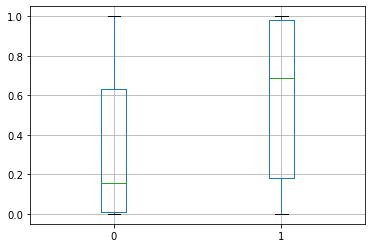

In [102]:
df_openmax.iloc[:,:-1].boxplot(showfliers=False)

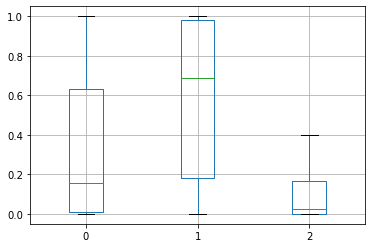

In [98]:
df_openmax.boxplot(showfliers=False)

In [ ]:
# custom 0
plt.figure(figsize=(28,16))
import umap
import umap.plot

mapper = umap.UMAP(random_state=seed).fit(np.array(prob_openmax))
umap.plot.points(mapper, labels=np.array(y_test))
# plt.savefig(f'{TEMP_DATADIR}/umap_{splitting}_{cust}_{layer_name}.eps', format='eps', bbox_inches = 'tight', pad_inches = 0)